<a href="https://colab.research.google.com/github/govindaa-sharma/project1/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Attempting to uninstall conflicting packages...")
!pip uninstall transformers -y -q
!pip uninstall tensorflow-text -y -q # This might not be installed, but try just in case
!pip uninstall tokenizers -y -q
print("Conflicting packages uninstalled (if present).")

# 2. Reinstall the latest transformers for Keras 3.x compatibility
# This should pull in the correct tokenizers version too.
print("Installing the latest compatible transformers library...")
!pip install transformers --upgrade --quiet
print("Transformers library installed.")


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import os
from io import BytesIO

from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print(f"TensorFlow Version: {tf.__version__}")

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


tf.random.set_seed(42)
np.random.seed(42)


IMG_HEIGHT = 224
IMG_WIDTH = 224

Attempting to uninstall conflicting packages...
Conflicting packages uninstalled (if present).
Installing the latest compatible transformers library...
Transformers library installed.
TensorFlow Version: 2.18.0
GPU Available: []


In [2]:
from google.colab import drive
drive.mount('/content/drive')
print('Google drive connected')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google drive connected


In [3]:
drive_zip_path = '/content/drive/MyDrive/fashion-product-images-small.zip'

In [5]:
extract_dir = 'fashion_data'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

In [6]:
print(f"Unzipping '{drive_zip_path}' to '{extract_dir}'...")
!unzip -q -n {drive_zip_path} -d {extract_dir}
print("Unzipping complete.")

Unzipping '/content/drive/MyDrive/fashion-product-images-small.zip' to 'fashion_data'...
Unzipping complete.


In [4]:
extract_dir = 'fashion_data'
csv_path = os.path.join(extract_dir, 'styles.csv')

In [5]:
try:
    df = pd.read_csv(csv_path, on_bad_lines='skip', low_memory=False)
except TypeError:
    df = pd.read_csv(csv_path, error_bad_lines=False, warn_bad_lines=True, low_memory=False)
print("Product details loaded successfully into DataFrame.")


Product details loaded successfully into DataFrame.


In [6]:
df.sample(4)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
24922,12532,Women,Apparel,Topwear,Jackets,Black,Fall,2011.0,Casual,Puma Women Solid Black Jackets
35553,3469,Unisex,Accessories,Headwear,Headband,Black,Fall,2010.0,Sports,ADIDAS Unisex Black White Headband
31700,24742,Women,Accessories,Bags,Handbags,Green,Winter,2015.0,Casual,Murcia Women Casual Handbag
42694,28477,Women,Apparel,Topwear,Kurtas,Purple,Summer,2012.0,Ethnic,Urban Yoga Women Printed Purple Kurta


In [7]:
df['image_path'] = df['id'].apply(lambda x: os.path.join(extract_dir, 'images', f'{x}.jpg'))

In [8]:
df.isna().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,15
season,21
year,1
usage,317
productDisplayName,7


In [9]:
df.dropna(subset=['baseColour','season','year', 'usage', 'productDisplayName', 'masterCategory'], inplace=True)

In [10]:
df = df[df['productDisplayName'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
df = df[df['masterCategory'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]

In [11]:
df['image_exists'] = df['image_path'].apply(lambda x: os.path.exists(x))
df = df[df['image_exists'] == True]
df.drop(columns=['image_exists'], inplace=True)

/tmp/ipython-input-11-4057592718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['image_exists'], inplace=True)


In [12]:
print(f"\nTotal products ready for processing: {len(df)}")
print(f"Number of unique main product categories: {df['masterCategory'].nunique()}")
print(f"Breakdown of products per category:\n{df['masterCategory'].value_counts()}")


Total products ready for processing: 44072
Number of unique main product categories: 7
Breakdown of products per category:
masterCategory
Apparel           21361
Accessories       11244
Footwear           9197
Personal Care      2139
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


In [13]:
# --- New Sub-step (After Step 1: Data Acquisition, before Step 2.1: Image Pre-processing) ---

print("\n--- Filtering Out Rare Product Categories ---")

# First, let's see how many products are in each category
category_counts = df['masterCategory'].value_counts()
print("Original category counts:")
print(category_counts)

# We want to remove categories that have too few products.
# The error specifically says "less than 2", so we must remove categories with only 1 product.
# For robustness and better learning, it's often good to remove categories with, say, less than 5 products.
MIN_SAMPLES_PER_CATEGORY = 5 # You can adjust this number (e.g., 2, 3, 10)

# Get a list of categories that meet our minimum sample requirement
categories_to_keep = category_counts[category_counts >= MIN_SAMPLES_PER_CATEGORY].index.tolist()

# Filter our main DataFrame to only include products from these "common" categories
df_filtered = df[df['masterCategory'].isin(categories_to_keep)].copy()

removed_categories_count = len(category_counts) - len(categories_to_keep)
removed_products_count = len(df) - len(df_filtered)

print(f"\nRemoved {removed_categories_count} categories with less than {MIN_SAMPLES_PER_CATEGORY} samples.")
print(f"Removed {removed_products_count} products belonging to these rare categories.")
print(f"New total number of products after filtering: {len(df_filtered)}")
print(f"New number of unique categories: {len(df_filtered['masterCategory'].unique())}")

# Replace the original DataFrame 'df' with the filtered one for all subsequent steps
df = df_filtered

print("\nUpdated category counts after filtering:")
print(df['masterCategory'].value_counts())


--- Filtering Out Rare Product Categories ---
Original category counts:
masterCategory
Apparel           21361
Accessories       11244
Footwear           9197
Personal Care      2139
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64

Removed 1 categories with less than 5 samples.
Removed 1 products belonging to these rare categories.
New total number of products after filtering: 44071
New number of unique categories: 6

Updated category counts after filtering:
masterCategory
Apparel           21361
Accessories       11244
Footwear           9197
Personal Care      2139
Free Items          105
Sporting Goods       25
Name: count, dtype: int64


In [14]:
def _load_and_preprocess_image_inner(image_path_bytes):
    image_path = image_path_bytes.decode('utf-8')

    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.array(img).astype(np.float32) / 255.0
        return img_array
    except Exception as e:
        print(f"Warning: Could not decode or load image {image_path}: {e}. Returning black image.")
        return np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)

def load_and_preprocess_image(image_path_tensor):
    image_tensor = tf.py_function(
        _load_and_preprocess_image_inner,
        [image_path_tensor],
        [tf.float32]
    )[0]

    image_tensor.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    return image_tensor

print("Image pre-processing function updated for tf.data.Dataset streaming compatibility.")

Image pre-processing function updated for tf.data.Dataset streaming compatibility.


In [15]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 64

def tokenize_func(text, tokenizer, max_length):
    encoded_input = tokenizer.batch_encode_plus(
        text.tolist(),
        max_length = max_length,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'tf'
    )
    return encoded_input['input_ids'], encoded_input['attention_mask']

x_input_ids , x_attention_mask = tokenize_func(df['productDisplayName'], tokenizer, MAX_LENGTH)
x_input_ids = x_input_ids.numpy()
x_attention_mask = x_attention_mask.numpy()

print(f"Shape of x_input_ids : {x_input_ids.shape}")
print(f"Shape of x_attention_mask : {x_attention_mask.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Shape of x_input_ids : (44071, 64)
Shape of x_attention_mask : (44071, 64)


In [16]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['masterCategory'])

label_classes = len(encoder.classes_)
y_one_hot = keras.utils.to_categorical(y_encoded, num_classes=label_classes)


print(f"Shape of y_encoded : {y_encoded.shape}")
print(f"Shape of y_one_hot : {y_one_hot.shape}")
print(f"Original product categories: {encoder.classes_}")
print(f"First 5 original categories: {df['masterCategory'].head().tolist()}")
print(f"First 5 one-hot encoded labels:\n{y_one_hot[:5]}")

Shape of y_encoded : (44071,)
Shape of y_one_hot : (44071, 6)
Original product categories: ['Accessories' 'Apparel' 'Footwear' 'Free Items' 'Personal Care'
 'Sporting Goods']
First 5 original categories: ['Apparel', 'Apparel', 'Accessories', 'Apparel', 'Apparel']
First 5 one-hot encoded labels:
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44071 entries, 0 to 44423
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44071 non-null  int64  
 1   gender              44071 non-null  object 
 2   masterCategory      44071 non-null  object 
 3   subCategory         44071 non-null  object 
 4   articleType         44071 non-null  object 
 5   baseColour          44071 non-null  object 
 6   season              44071 non-null  object 
 7   year                44071 non-null  float64
 8   usage               44071 non-null  object 
 9   productDisplayName  44071 non-null  object 
 10  image_path          44071 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.0+ MB



How many products are in each main category (distribution):


/tmp/ipython-input-18-1126165046.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='masterCategory', order=df['masterCategory'].value_counts().index, palette='viridis')


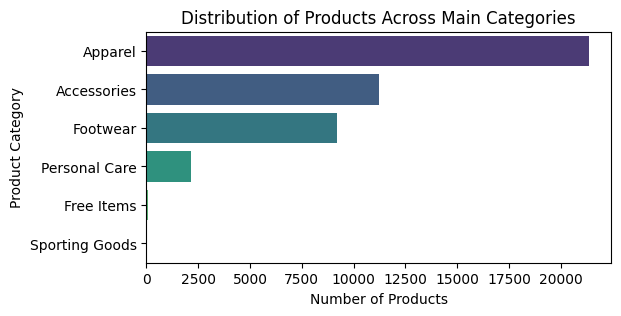

In [18]:
print("\nHow many products are in each main category (distribution):")
plt.figure(figsize=(6, 3))
sns.countplot(data=df, y='masterCategory', order=df['masterCategory'].value_counts().index, palette='viridis')
plt.title('Distribution of Products Across Main Categories')
plt.xlabel('Number of Products')
plt.ylabel('Product Category')
plt.show()


Length of product titles (number of words):


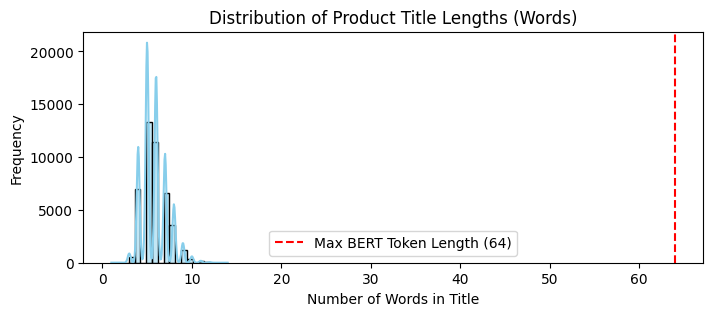

In [19]:
print("\nLength of product titles (number of words):")
df['title_length'] = df['productDisplayName'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 3))
sns.histplot(df['title_length'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Product Title Lengths (Words)')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.axvline(MAX_LENGTH, color='red', linestyle='--', label=f'Max BERT Token Length ({MAX_LENGTH})')
plt.legend()
plt.show()

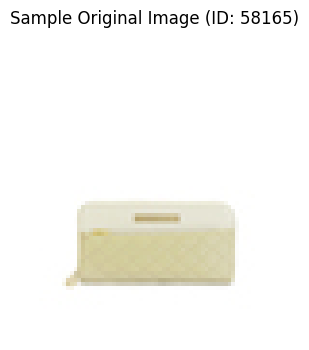

In [20]:
sample_idx = 18888
sample_original_img = Image.open(df['image_path'].iloc[sample_idx])
plt.figure(figsize=(4, 4))
plt.imshow(sample_original_img)
plt.title(f"Sample Original Image (ID: {df['id'].iloc[sample_idx]})")
plt.axis('off')
plt.show()

In [21]:
sample_title = df['productDisplayName'].iloc[sample_idx]
print(f"\nOriginal Sample Title: '{sample_title}'")
tokenized_sample = tokenizer.encode_plus(
    sample_title,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
print(f"BERT Input IDs (first 20): {tokenized_sample['input_ids'][0, :20].numpy()}")
print(f"BERT Attention Mask (first 20): {tokenized_sample['attention_mask'][0, :20].numpy()}")
print(f"Decoded BERT Tokens (first 20): {tokenizer.convert_ids_to_tokens(tokenized_sample['input_ids'][0, :20].numpy())}")



Original Sample Title: 'Rocky S Women Cream Wallet'
BERT Input IDs (first 20): [  101  6857  1055  2308  6949 15882   102     0     0     0     0     0
     0     0     0     0     0     0     0     0]
BERT Attention Mask (first 20): [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoded BERT Tokens (first 20): ['[CLS]', 'rocky', 's', 'women', 'cream', 'wallet', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [22]:
x_train_images_path, x_temp_images_path, \
x_train_input_ids, x_temp_input_ids, \
x_train_mask, x_temp_mask, \
y_train, y_temp = train_test_split(df['image_path'], x_input_ids, x_attention_mask, y_one_hot, test_size=0.3, random_state=42, stratify=y_one_hot)


In [23]:
x_val_images_path , x_test_images_path, \
x_val_input_ids, x_test_input_ids, \
x_val_mask, x_test_mask, \
y_val, y_test = train_test_split(x_temp_images_path, x_temp_input_ids, x_temp_mask, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [24]:
print(f"Number of products for Training: {len(x_train_images_path)}")
print(f"Number of products for Validation: {len(x_val_images_path)}")
print(f"Number of products for Testing: {len(x_test_images_path)}")


print(f"Shapes of training data:")
print(f"  Images: {x_train_images_path.shape}")
print(f"  Text Input IDs: {x_train_input_ids.shape}")
print(f"  Text Attention Mask: {x_train_mask.shape}")
print(f"  Labels: {y_train.shape}")

Number of products for Training: 30849
Number of products for Validation: 6611
Number of products for Testing: 6611
Shapes of training data:
  Images: (30849,)
  Text Input IDs: (30849, 64)
  Text Attention Mask: (30849, 64)
  Labels: (30849, 6)


In [25]:
GLOBAL_BATCH_SIZE = 64

def load_sample(image_path, input_id, input_mask, label):
    img = load_and_preprocess_image(image_path)

    return {
        'image_input': img,
        'input_mask':input_mask,
        'input_id': input_id
    }, label


In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    x_train_images_path, x_train_input_ids, x_train_mask, y_train
))

In [27]:
train_dataset = train_dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1024).batch(GLOBAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [28]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    x_val_images_path, x_val_input_ids, x_val_mask, y_val
))
val_dataset = val_dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(GLOBAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [29]:
image_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='image_input')


base_cnn = keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

base_cnn.trainable = False

x_img = base_cnn(image_input)
x_img = layers.GlobalAveragePooling2D(name='image_global_avg_pooling')(x_img)


input_ids = keras.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = keras.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')

bert_model = TFAutoModel.from_pretrained('bert-base-uncased')

bert_model.trainable = False

bert_output_tuple = bert_model(input_ids, attention_mask=attention_mask, return_dict=False)
x_text = bert_output_tuple[1]


concatenated_features = layers.concatenate([x_img, x_text], name='concatenate_features')


x = layers.Dense(256, activation='relu', name='dense_1')(concatenated_features)
x = layers.Dropout(0.3, name='dropout_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)

output = layers.Dense(label_classes, activation='softmax', name='output_layer')(x)


model = keras.Model(inputs=[image_input, input_ids, attention_mask], outputs=output, name='Product_Classifier_Model')

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were 

ValueError: Exception encountered when calling layer 'tf_bert_model' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for attention_mask.

Call arguments received by layer 'tf_bert_model' (type TFBertModel):
  • input_ids=<KerasTensor shape=(None, 64), dtype=int32, sparse=False, name=input_ids>
  • attention_mask=<KerasTensor shape=(None, 64), dtype=int32, sparse=False, name=attention_mask>
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=False
  • training=False